
11490434/11490434 [==============================] - 10s 1us/step



Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  100480    ['encoder_input[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 32)                   2080      ['dense_1[0][0]']             
                      

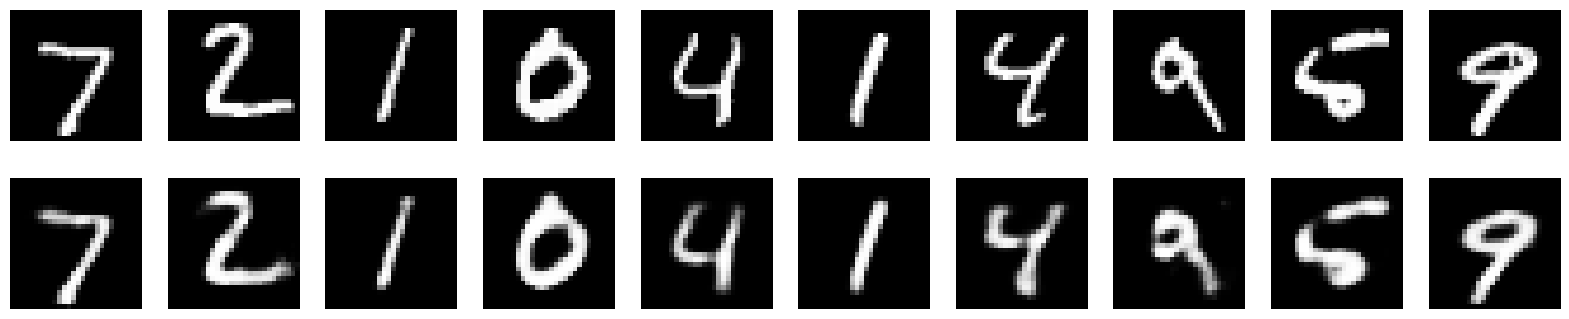

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K

# Load MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

original_dim = 784
intermediate_dim1 = 128
intermediate_dim2 = 64
latent_dim = 32
beta = 1.0  # weighting for KL term (beta-VAE). Set >1 to emphasize KL.

# Encoder
inputs = Input(shape=(original_dim,), name="encoder_input")
h = Dense(intermediate_dim1, activation="relu")(inputs)
h = Dense(intermediate_dim2, activation="relu")(h)

# Instead of a single latent vector, we output mean and log-variance
z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_var = Dense(latent_dim, name="z_log_var")(h)

# Sampling layer (reparameterization trick)
def sampling(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * eps

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Decoder
decoder_h1 = Dense(intermediate_dim2, activation="relu")
decoder_h2 = Dense(intermediate_dim1, activation="relu")
decoder_out = Dense(original_dim, activation="sigmoid")

h_decoded = decoder_h1(z)
h_decoded = decoder_h2(h_decoded)
outputs = decoder_out(h_decoded)

# VAE model
vae = Model(inputs, outputs, name="vae_mlp")

# Reconstruction loss (binary crossentropy per-sample)
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
# binary_crossentropy returns per-element mean by default; multiply by original_dim to get sum of pixels:
reconstruction_loss = reconstruction_loss * original_dim
reconstruction_loss = K.sum(reconstruction_loss, axis=-1)  # shape: (batch,)

# KL divergence (per sample)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  # shape: (batch,)

# Total loss: mean over batch. You can weight KL by beta (beta-VAE).
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()

# Train
history = vae.fit(
    x_train,
    None,  # targets not needed since loss is in add_loss()
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, None)
)

# Build a separate decoder model for easy sampling / reconstruction if desired
# (optional) decoder from latent input to image
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
x = decoder_h1(latent_inputs)
x = decoder_h2(x)
decoder_outputs = decoder_out(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# Reconstruct some digits
decoded_imgs = vae.predict(x_test[:10])

# Plot original vs reconstructed
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.show()
